# Install Torch with CUDA

In [8]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q

In [9]:
# import torch
# print(torch.cuda.is_available())  # Should return True if GPU is available

# Download Dataset

In [10]:
# !pip install gdown -q

This cell might take more than 1 minute to run

In [11]:
# import os
# import gdown
# import zipfile

# # URL of the zip file on Google Drive
# url = 'https://drive.google.com/file/d/1OXoi4UeZy726ILuPM6Y57sr4eZhqrhq2/view?usp=sharing'

# # Function to download the zip file and extract it
# def download_and_extract_zip(url, extract_to='PlantVillage'):
#     # Generate the direct download URL for the file
#     file_id = url.split('/d/')[1].split('/')[0]
#     download_url = f'https://drive.google.com/uc?id={file_id}'

#     # Download the zip file
#     zip_file = 'PlantVillage.zip'
#     gdown.download(download_url, zip_file, quiet=False)

#     # Extract the zip file directly
#     with zipfile.ZipFile(zip_file, 'r') as zip_ref:
#         # Extract all the files directly into the 'extract_to' folder
#         zip_ref.extractall(extract_to)

#     # Remove the zip file after extraction
#     os.remove(zip_file)

# # Check if the 'PlantVillage' folder exists
# if not os.path.exists('PlantVillage') or not os.listdir('PlantVillage'):
#     download_and_extract_zip(url)

# Prepare Dataset

In [12]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transformations for your dataset
image_width = 32
transform = transforms.Compose([
    transforms.Resize((image_width, image_width)),  # Resize all images to 128x128
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load train dataset
train_path = os.path.join('PlantVillage', 'train')
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)

# Load val dataset
val_path = os.path.join('PlantVillage', 'val')
val_dataset = datasets.ImageFolder(root=val_path, transform=transform)

# Split val dataset into val and test
test_split = 0.5  # Use 50% of the current val set as the test set
test_size = int(test_split * len(val_dataset))
val_size = len(val_dataset) - test_size

val_dataset, test_dataset = random_split(val_dataset, [val_size, test_size])

# Create DataLoaders for train, val, and test datasets
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Function to count class instances with a progress bar
def count_classes(dataset):
    class_counter = Counter()
    for _, label in tqdm(dataset, desc="Counting classes"):
        class_counter[label] += 1
    return class_counter

# Access class-to-index mapping
class_to_idx = train_dataset.class_to_idx
print("Class to index mapping:", class_to_idx)

def count_classes_in_folders(dataset_path):
    """
    Count the number of items in each class folder in the dataset.
    """
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):  # Ensure it's a directory
            class_counts[class_name] = len(os.listdir(class_folder))
    return class_counts

# Count classes
train_class_counts = count_classes_in_folders(train_path)

# Create a DataFrame from the train_class_counts dictionary
class_df = pd.DataFrame(list(train_class_counts.items()), columns=["Class", "Count"])

# Sort the DataFrame by 'Count' in ascending order
class_df_sorted = class_df.sort_values(by="Count", ascending=True).reset_index(drop=True)

# Print the sorted DataFrame
print(class_df_sorted)

Class to index mapping: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___L

# Model

In [13]:
import torch
import torch.nn as nn


class SimpleCNN(nn.Module):
    def __init__(self, num_classes, image_width):
        super(SimpleCNN, self).__init__()  # Call the parent class constructor
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # nn.Conv2d(35, 60, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(60),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Dropout(0.20)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * (image_width//4)**2, 512),
            nn.ReLU(),
            nn.Dropout(0.45),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# Training

In [14]:
import torch.optim as optim


# Model, loss function, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes=num_classes, image_width=image_width).to(device)  # Move model to device
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set maximum number of epochs and patience for early stopping
max_epochs = 40
patience = 5  # Number of epochs with no improvement after which training will stop
best_val_loss = float('inf')  # Initialize best validation loss as infinity
epochs_without_improvement = 0

# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    train_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}", unit="batch")  # Add tqdm to training loop
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_loader.set_postfix(loss=loss.item())  # Update tqdm progress bar with current loss
    
    print(f"Epoch {epoch+1}, Average Loss: {(running_loss / len(train_loader)):.4f}")

    # Evaluate on the validation dataset
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation during evaluation
        for images, labels in val_loader:  # Assuming val_loader is the DataLoader for the test/validation set
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    
    # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break  # Stop training early if no improvement

    # Check if we have reached the maximum number of epochs
    if epoch + 1 == max_epochs:
        print("Maximum number of epochs reached.")
        break

Epoch 1/40: 100%|██████████| 1358/1358 [00:07<00:00, 172.35batch/s, loss=0.75] 

Epoch 1, Average Loss: 1.3509


Validation Accuracy: 79.16%
Validation Loss: 0.6792


Epoch 2/40: 100%|██████████| 1358/1358 [00:07<00:00, 176.09batch/s, loss=0.406]

Epoch 2, Average Loss: 0.6843


Validation Accuracy: 86.98%
Validation Loss: 0.4160


Epoch 3/40: 100%|██████████| 1358/1358 [00:07<00:00, 174.46batch/s, loss=0.603]

Epoch 3, Average Loss: 0.5122


Validation Accuracy: 87.98%
Validation Loss: 0.3688


Epoch 4/40: 100%|██████████| 1358/1358 [00:07<00:00, 179.95batch/s, loss=0.233] 

Epoch 4, Average Loss: 0.4223


Validation Accuracy: 90.46%
Validation Loss: 0.2997


Epoch 5/40: 100%|██████████| 1358/1358 [00:07<00:00, 180.96batch/s, loss=0.336] 

Epoch 5, Average Loss: 0.3650


Validation Accuracy: 91.44%
Validation Loss: 0.2553


Epoch 6/40: 100%|██████████| 1358/1358 [00:07<00:00, 182.63batch/s, loss=0.776] 


Epoch 6, Average Loss: 0.3167
Validation Accuracy: 92.29%
Validation Loss: 0.2399


Epoch 7/40: 100%|██████████| 1358/1358 [00:07<00:00, 182.56batch/s, loss=0.249] 

Epoch 7, Average Loss: 0.2849


Validation Accuracy: 92.82%
Validation Loss: 0.2226


Epoch 8/40: 100%|██████████| 1358/1358 [00:07<00:00, 183.55batch/s, loss=0.113] 

Epoch 8, Average Loss: 0.2586


Validation Accuracy: 92.80%
Validation Loss: 0.2131


Epoch 9/40: 100%|██████████| 1358/1358 [00:07<00:00, 180.18batch/s, loss=0.0197]

Epoch 9, Average Loss: 0.2414


Validation Accuracy: 93.87%
Validation Loss: 0.1840


Epoch 10/40: 100%|██████████| 1358/1358 [00:07<00:00, 185.20batch/s, loss=0.13]  

Epoch 10, Average Loss: 0.2194


Validation Accuracy: 93.76%
Validation Loss: 0.1892


Epoch 11/40: 100%|██████████| 1358/1358 [00:07<00:00, 180.06batch/s, loss=0.272] 


Epoch 11, Average Loss: 0.2026
Validation Accuracy: 94.53%
Validation Loss: 0.1788


Epoch 12/40: 100%|██████████| 1358/1358 [00:07<00:00, 185.01batch/s, loss=0.283] 

Epoch 12, Average Loss: 0.1874


Validation Accuracy: 94.49%
Validation Loss: 0.1727


Epoch 13/40: 100%|██████████| 1358/1358 [00:07<00:00, 182.06batch/s, loss=0.101] 


Epoch 13, Average Loss: 0.1812
Validation Accuracy: 94.42%
Validation Loss: 0.1783


Epoch 14/40: 100%|██████████| 1358/1358 [00:07<00:00, 180.19batch/s, loss=0.0404] 

Epoch 14, Average Loss: 0.1609


Validation Accuracy: 94.64%
Validation Loss: 0.1689


Epoch 15/40: 100%|██████████| 1358/1358 [00:07<00:00, 178.95batch/s, loss=0.227]  

Epoch 15, Average Loss: 0.1601


Validation Accuracy: 94.46%
Validation Loss: 0.1842


Epoch 16/40: 100%|██████████| 1358/1358 [00:07<00:00, 176.44batch/s, loss=0.317]  

Epoch 16, Average Loss: 0.1537


Validation Accuracy: 95.16%
Validation Loss: 0.1516


Epoch 17/40: 100%|██████████| 1358/1358 [00:07<00:00, 174.92batch/s, loss=0.261]  

Epoch 17, Average Loss: 0.1467


Validation Accuracy: 95.23%
Validation Loss: 0.1545


Epoch 18/40: 100%|██████████| 1358/1358 [00:07<00:00, 170.51batch/s, loss=0.0933]

Epoch 18, Average Loss: 0.1385


Validation Accuracy: 94.94%
Validation Loss: 0.1667


Epoch 19/40: 100%|██████████| 1358/1358 [00:07<00:00, 177.87batch/s, loss=0.244]  

Epoch 19, Average Loss: 0.1370


Validation Accuracy: 95.27%
Validation Loss: 0.1516


Epoch 20/40: 100%|██████████| 1358/1358 [00:07<00:00, 180.34batch/s, loss=0.358]  

Epoch 20, Average Loss: 0.1322


Validation Accuracy: 95.40%
Validation Loss: 0.1498


Epoch 21/40: 100%|██████████| 1358/1358 [00:07<00:00, 185.04batch/s, loss=0.0802] 

Epoch 21, Average Loss: 0.1225


Validation Accuracy: 95.08%
Validation Loss: 0.1556


Epoch 22/40: 100%|██████████| 1358/1358 [00:07<00:00, 180.04batch/s, loss=0.0553] 

Epoch 22, Average Loss: 0.1177


Validation Accuracy: 95.34%
Validation Loss: 0.1543


Epoch 23/40: 100%|██████████| 1358/1358 [00:07<00:00, 178.74batch/s, loss=0.171]  

Epoch 23, Average Loss: 0.1168


Validation Accuracy: 94.70%
Validation Loss: 0.1635


Epoch 24/40: 100%|██████████| 1358/1358 [00:07<00:00, 176.01batch/s, loss=0.148]  

Epoch 24, Average Loss: 0.1086


Validation Accuracy: 94.95%
Validation Loss: 0.1761


Epoch 25/40: 100%|██████████| 1358/1358 [00:07<00:00, 177.69batch/s, loss=0.0908] 

Epoch 25, Average Loss: 0.1097


Validation Accuracy: 95.56%
Validation Loss: 0.1598
Early stopping triggered after 25 epochs.


# Testing

In [15]:
from sklearn.metrics import f1_score

# Evaluate on the test dataset with tqdm
model.eval()
correct = 0
total = 0
all_labels = []  # To store true labels
all_preds = []   # To store predicted labels
test_loader = tqdm(test_loader, desc="Testing", unit="batch")  # Add tqdm for the test loop

with torch.no_grad():  # Disable gradient computation during evaluation
    for images, labels in test_loader:  # Loop through test dataset
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())  # Append true labels
        all_preds.extend(predicted.cpu().numpy())  # Append predicted labels
        
        # Update tqdm bar with current accuracy
        test_loader.set_postfix(accuracy=(100 * correct / total))  

# Compute test accuracy
test_accuracy = 100 * correct / total

# Compute F1 score for the whole dataset
f1 = f1_score(all_labels, all_preds, average='weighted')  # You can also use 'macro' or 'micro' as needed

print(f"\nTest Accuracy: {test_accuracy:.2f}%")
print(f"Test F1 Score (Weighted): {f1:.4f}")

Testing: 100%|██████████| 170/170 [00:01<00:00, 165.47batch/s, accuracy=94.9]



Test Accuracy: 94.88%
Test F1 Score (Weighted): 0.9483


                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.90      0.88      0.89        73
                                 Apple___Black_rot       0.89      0.98      0.94        59
                          Apple___Cedar_apple_rust       0.94      0.71      0.81        21
                                   Apple___healthy       0.95      0.94      0.94       179
                               Blueberry___healthy       0.94      0.96      0.95       137
          Cherry_(including_sour)___Powdery_mildew       0.94      0.97      0.96       113
                 Cherry_(including_sour)___healthy       0.96      0.97      0.97        79
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.93      0.81      0.87        48
                       Corn_(maize)___Common_rust_       0.98      0.98      0.98       122
               Corn_(maize)___Northern_Leaf_Blight       0.94      0.94      0.

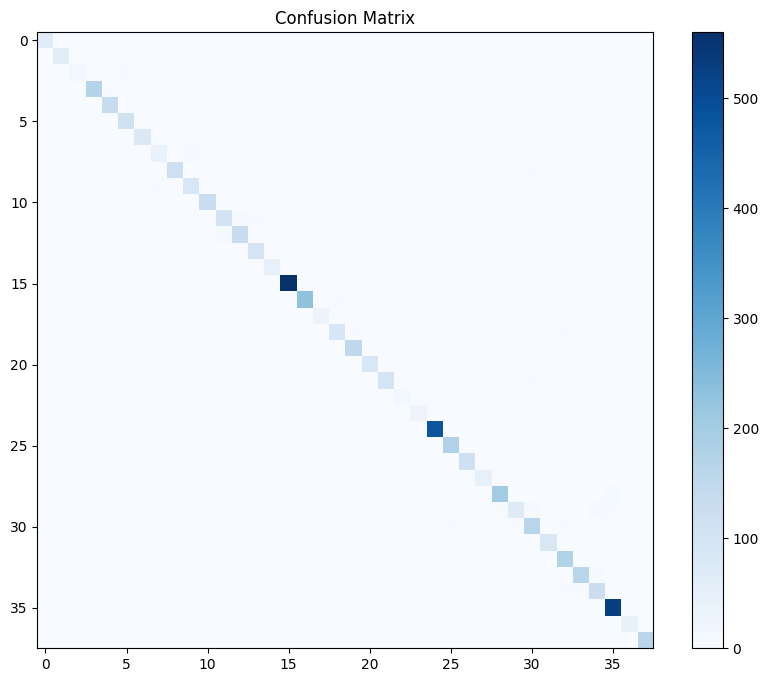

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

class_names = train_dataset.classes

def evaluate_model(model, val_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.show()

evaluate_model(model, val_loader)

In [17]:
# Save model to file
torch.save(model.state_dict(), 'plant_disease_model.pth')

In [18]:
# Retrieve model from file 
model.load_state_dict(torch.load('plant_disease_model.pth'))
model = model.to(device)

Predict Image

In [25]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# Load the trained model
model.load_state_dict(torch.load('plant_disease_model.pth'))
model.eval()
model.to(device)

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((image_width, image_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load and preprocess the image
image_path = "test.JPG"  # Replace with your image path
image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0).to(device)

# Perform the prediction
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted_class = torch.max(outputs, 1)

# Map index to class label
predicted_label = train_dataset.classes[predicted_class.item()]
probabilities = torch.nn.functional.softmax(outputs, dim=1)
predicted_prob = probabilities[0, predicted_class].item()

print(f"The predicted class is: {predicted_label} with probability {predicted_prob:.4f}")

The predicted class is: Pepper,_bell___healthy with probability 0.9992
